# Exercise class 6: Stochastic Gradient Descent 

Luca Calatroni (calatroni@i3s.unice.fr)

For a least-square regression problem with an $\ell_2$ ridge regression, the objective of this lab session is to implement:
- SGD algorith with constant stepsizes
- SGD algorithm with shrinking stepsizes
- SGD with late averaging 
- SGD with momentum 

and compare your solution with the one found by deterministic solvers.

This exercise class is largely inspired by the one given by Robert Gower at the Cornell course on optimization for machine learning given in 2020, please check: https://gowerrobert.github.io/.

In [1]:
# Import useful packages and routines

import numpy as np
from numpy import linalg as la
from scipy.linalg import norm
import matplotlib.pyplot as plt

<a id='loss'></a>
## 1. Loss functions, gradients and Lipschitz constants

Given $b\in\mathbb{R}^n$, a model matrix $\mathbf{X} = [x_1, \ldots, x_n]^T \in\mathbb{R}^{n\times d}$, $\lambda> 0$ we want to solve the linear regression problem

$$
\text{find }\quad w\in\mathbb{R}^d\quad\text{ s.t. }\quad b=\mathbf{X}w + n.
$$

A linear regression model takes the form:

$$
b_i = x_i^T w + n_i
$$

where for $i=1,\ldots,n$ $x_i\in\mathbb{R}^d$ is the vector with components $x_i = (x_{j,i})_{j=1,\ldots,d}$. 

*Standard approach (inverse problem type)*: least-square regression with ridge regularization:

$$
\min_{w\in\mathbb{R}^d}~ \left\{ f(w):=\frac{1}{2n} \sum_{i=1}^n | x_i^\top w- b_i |^2 + \frac \lambda 2 \|w\|_2^2 \right\}
$$

Note that $f$ is smooth and convex. We write it as a a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(w)
$$
where
$$
f_i(w) = \frac 12 | x_i^\top w- b_i |^2 + \frac \lambda 2 \|w\|_2^2.
$$

The gradient reads:
$$
\nabla f_i(w) = (x_i^\top w - y_i) x_i + \lambda w
$$


Denote by $L$ the Lipschitz constant of $\nabla f$.
One can check that:
$$
L = \frac{ \|\mathbf X \mathbf X^\top \|_{2}}{n} + \lambda.
$$

Recall that for classical (non-stochastic) gradient descent algorithm, the upper bound on the step-size is $1 / L$.

Introduce a solver class first.

In [2]:
from scipy.linalg import svd

class LinReg(object):
    """A class for the least-squares regression with
    Ridge penalization"""

    def __init__(self, X, y, lbda):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
        self.lbda = lbda  
# global gradient \nabla f  
    def grad(self, w):
        return self.X.T.dot(self.X.dot(w) - self.y) / self.n + self.lbda * w
# definition of components f_i 
    def f_i(self, i, w):
        return norm(self.X[i].dot(w) - self.y[i]) ** 2 / (2.) + self.lbda * norm(w) ** 2 / 2.  
# definition of f   
    def f(self, w):
        return norm(self.X.dot(w) - self.y) ** 2 / (2. * self.n) + self.lbda * norm(w) ** 2 / 2.
# gradient of component, \nabla f_i  
    def grad_i(self, i, w):
        x_i = self.X[i]
        return (x_i.dot(w) - self.y[i]) * x_i + self.lbda * w

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient of the global function"""
        L = norm(self.X, ord=2) ** 2 / self.n + self.lbda
        return L
    
    def L_max_constant(self):
        """Return the L_max constant among all components """
        L_max = np.max(np.sum(self.X ** 2, axis=1)) + self.lbda
        return L_max 
    
    def mu_constant(self):
        """Return the strong convexity constant"""
        mu =  min(abs(la.eigvals(np.dot(self.X.T,self.X)))) / self.n + self.lbda
        return mu     

# 2. Dataset generation

We generate the datasets. First, let us define the function.

In [3]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz

    
def simu_linreg(w, n, std=1., corr=0.5):
    """
    Simulation of the least-squares problem
    
    Parameters
    ----------
    x : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the features matrix
    """    
    d = w.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    X = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    y = X.dot(w) + noise
    return X, y

C:\Users\Raffaele\AppData\Local\Temp\ipykernel_12220\3322846575.py:2: DeprecationWarning: Please use `toeplitz` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import toeplitz


In [4]:
d = 50
n = 1000
idx = np.arange(d)

# Ground truth coefficients of the model
w_model_truth = (-1)**idx * np.exp(-idx / 10.)

X, y = simu_linreg(w_model_truth, n, std=1., corr=0.25)

In [5]:
lbda = 1. / n ** (0.5)
model = LinReg(X, y, lbda)  # forward problem

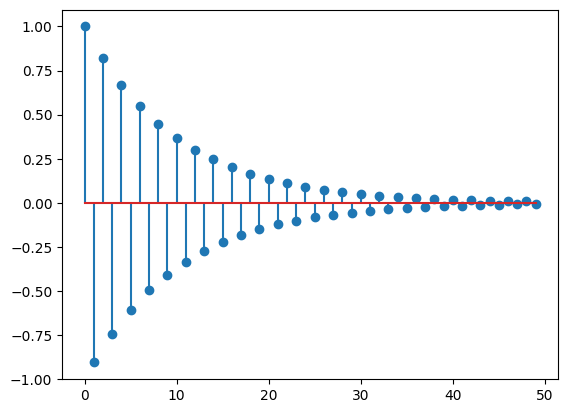

In [6]:
plt.stem(w_model_truth);  # plot of ground truth w

In [ ]:
from scipy.optimize import check_grad
model_lin = LinReg(X, y, lbda)
# Check that the computation of the gradient done by scipy and the one done manually match in correspondence of a random point
check_grad(model_lin.f, model_lin.grad, np.random.randn(d))

2.563078509059794e-06


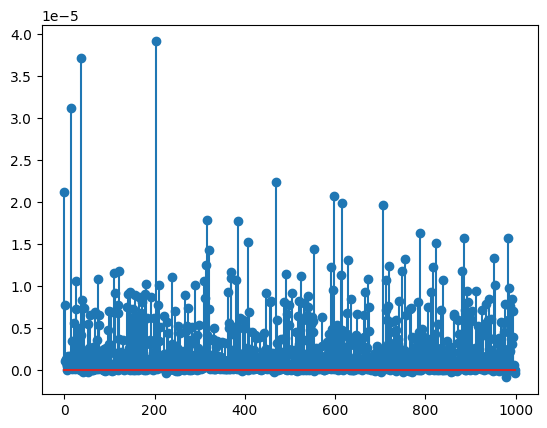

In [15]:
# Check that the gradient grad_i and the numerical gradient of f_i (incremental ratio) agree
grad_error = []
for i in range(n):
    ind = np.random.choice(n,1)
    w =  np.random.randn(d)
    vec =  np.random.randn(d)
    eps = pow(10.0, -7.0)
    model.f_i(ind[0],w)
    grad_error.append((model.f_i( ind[0], w+eps*vec) - model.f_i( ind[0], w))/eps - np.dot(model.grad_i(ind[0],w),vec))
plt.stem(grad_error); 
print(np.mean(grad_error))

### Find a highly accurate solution using LBFGS method

LBFGS is a Newton-type solver for the problem. It can rarely be applied in practical situations as it requires the computation of full gradients (for Hessian approximation). We use this to find a solution to compare to.

In [16]:
from scipy.optimize import fmin_l_bfgs_b

w_init = np.zeros(d)
w_min, obj_min, _ = fmin_l_bfgs_b(model.f, w_init, model.grad, args=(), pgtol=1e-30, factr =1e-30)

print(obj_min)
print(norm(model.grad(w_min)))

0.5330528084969917
9.636832174980504e-10


## 3. Plain SGD


**for** $k=1,\ldots,\texttt{maxiter}$
  
$\qquad$ Pick $i$ uniformly at random in $\{1, \ldots, n\}$
   
$\qquad \displaystyle
w_{k+1} \gets w_k - \tau_k \nabla f_i(w_k)
$
  
**till convergence**


**Complete the code** writing the SGD iteration. The inputs are

- n_iter: The number of iterations $\texttt{maxiter}$ of the SGD algorithm
- indices: an np.array of indices of length n_iter. The indices[k]  is the random index of the that will be used for the computation of the kth iteration. 
- steps: an np.array of positive floats of length n_iter. The steps[k] is the stepsize $\tau_k$ used on the kth iteration. Either fixed or decreasing stepsizes are used $\tau_k = \frac{C}{k+1}$, where $C$ is tuned.

- averaging_on: is a boolean which indicates if the output should be the average of the iterates.

The outputs are:
- x_output: The final x vector found by the algorithm or the average  $ \bar{w} = \frac{1}{\texttt{maxiter}-k}\sum_{i=k}^{\texttt{maxiter}} w_k$ if averaging is on
- objectives: A ndarray containing the sequence function values calculated during the iterations of the algorithm 
- errors: If w_min is not empty, errors is a ndarray containing the sequence of errors || w - w_min || of the algorithm. For us w_min is the solution computed by LBFGS. Otherwise errors should be empty.


In [18]:
def sgd(w0, model, indices, steps, w_min, n_iter=100, averaging_on=False, momentum =0, verbose=True, start_late_averaging = 0):
    """Stochastic gradient descent algorithm
    """
    w = w0.copy()
    w_new = w0.copy()
    n_samples, n_features = X.shape
    # average x
    w_average = w0.copy()
    w_test = w0.copy()
    w_old = w0.copy()
    # estimation error history
    errors = []
    err = 1.0
    # objective history
    objectives = []
    # Current estimation error
    if np.any(w_min):
        err = norm(w - w_min) / norm(w_min)
        errors.append(err)
    # Current objective
    obj = model.f(w) 
    objectives.append(obj)
    if verbose:
        print("Lauching SGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter):
        
        # Write here SGD update
        w_new[:] = w - steps[k]*model.grad_i(indices[k], w)
        
        # Write here SGD with momentum update
        w_new[:] = w - steps[k]*model.grad_i(indices[k], w) + momentum*(w-w_old)
        w_old[:] = w
        
        # Update step
        w[:] = w_new
        
        # Write here late averaging condition
        
        if k<start_late_averaging:
            w_average[:]= w
        else:
            k_new =k-start_late_averaging
            w_average[:] = k_new/(k_new+1)*w_average + w/(k_new+1)

        
        if averaging_on:
            w_test[:] = w_average
        else:
            w_test[:] = w
        obj = model.f(w_test) 
        if np.any(w_min):
            err = norm(w_test - w_min) / norm(w_min)
            errors.append(err)
        objectives.append(obj)
        if k % n_samples == 0 and verbose:
            if(sum(w_min)):
                print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
            else:
                print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8)]))
    if averaging_on:
        w_output = w_average.copy()
    else:
        w_output = w.copy()    
    return w_output, np.array(objectives), np.array(errors)

In [13]:
##Setup number of iterations/passes
datapasses = 20  # number of sweeps through all the data. This means that there will datapasses*n stochastic gradient updates
n_iter = int(datapasses * n)

### SGD with constant step

Implement SGD withconstant stepsize  $\tau_k \equiv \tau = 1/(2L_{\max})$ for all $k=1,\ldots,\texttt{maxiter}$.

In [19]:
indices = np.random.choice(n, n_iter, replace=True)  #generate beforehand the vector of random components (with replacement)
#np.size(indices)

Lmax = model.L_max_constant(); 
steps =  np.ones(n_iter )/(2*Lmax)

w0 = np.zeros(d)
#averaging_on=False, momentum =0, verbose=True, start_late_averaging = 0
w_sgdcr, obj_sgdcr, err_sgdcr = sgd(w0,model, indices, steps, w_min,n_iter)

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 2.25e+00 | 1.00e+00
    1000 | 6.07e-01 | 1.62e-01
    2000 | 5.93e-01 | 1.54e-01
    3000 | 6.00e-01 | 1.59e-01
    4000 | 6.16e-01 | 1.66e-01
    5000 | 6.24e-01 | 1.94e-01
    6000 | 6.06e-01 | 1.82e-01
    7000 | 6.11e-01 | 1.75e-01
    8000 | 6.16e-01 | 1.74e-01
    9000 | 5.88e-01 | 1.46e-01
   10000 | 5.79e-01 | 1.31e-01
   11000 | 6.02e-01 | 1.68e-01
   12000 | 6.14e-01 | 1.76e-01
   13000 | 5.87e-01 | 1.43e-01
   14000 | 6.37e-01 | 1.85e-01
   15000 | 6.22e-01 | 1.78e-01
   16000 | 6.03e-01 | 1.54e-01
   17000 | 5.89e-01 | 1.48e-01
   18000 | 5.89e-01 | 1.53e-01
   19000 | 6.29e-01 | 1.89e-01


### SGD with decaying step-sizes

Run SGD with the decreasing choice of $\tau_k = \frac{C}{\sqrt{k+1}}$, where $C=\frac{2}{L_{max}}$.

In [20]:
# Write here the vector steps of decreasing step-sizes
steps = 2/(Lmax*(np.sqrt(np.arange(1, n_iter+2))))
w_sgdsr, obj_sgdsr, err_sgdsr = sgd(w0,model, indices, steps, w_min, n_iter)

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 2.26e+00 | 1.00e+00
    1000 | 8.23e-01 | 4.32e-01
    2000 | 6.80e-01 | 3.09e-01
    3000 | 6.20e-01 | 2.39e-01
    4000 | 5.91e-01 | 1.95e-01
    5000 | 5.78e-01 | 1.70e-01
    6000 | 5.66e-01 | 1.46e-01
    7000 | 5.58e-01 | 1.24e-01
    8000 | 5.52e-01 | 1.10e-01
    9000 | 5.48e-01 | 9.70e-02
   10000 | 5.44e-01 | 8.59e-02
   11000 | 5.42e-01 | 7.62e-02
   12000 | 5.40e-01 | 6.70e-02
   13000 | 5.39e-01 | 6.15e-02
   14000 | 5.38e-01 | 5.60e-02
   15000 | 5.37e-01 | 4.85e-02
   16000 | 5.37e-01 | 4.79e-02
   17000 | 5.37e-01 | 4.44e-02
   18000 | 5.36e-01 | 4.07e-02
   19000 | 5.36e-01 | 3.77e-02


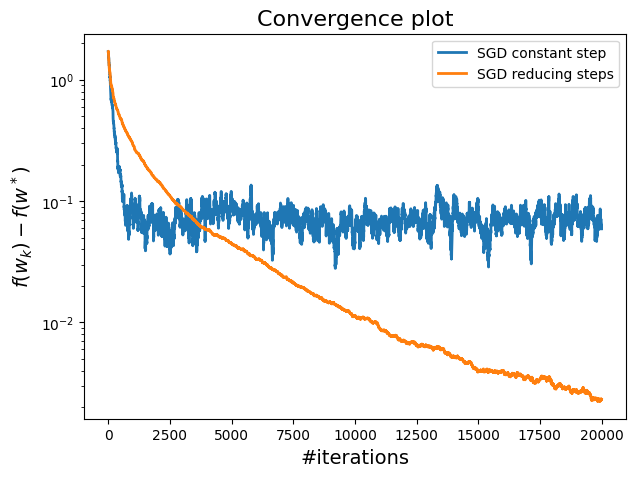

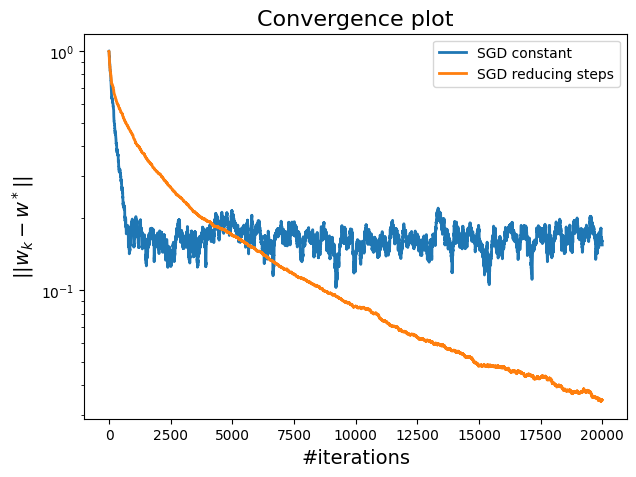

In [21]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgdcr - obj_min, label="SGD constant step", lw=2)
plt.semilogy(obj_sgdsr - obj_min, label="SGD reducing steps", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("$f(w_k) - f(w^*)$", fontsize=14)
plt.legend()
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.semilogy(err_sgdcr , label="SGD constant", lw=2)
plt.semilogy(err_sgdsr , label="SGD reducing steps", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("$|| w_k - w^* ||$", fontsize=14)
plt.legend()

### SGD with switch to  shrinking stepsizes

In [22]:
mu = model.mu_constant()
Kappa = Lmax/mu
kstar = 4*int(np.ceil(Kappa))

Test SGD with the following switching stepsizes given in the lecture

$\tau_k= 
\begin{cases}
\displaystyle \tfrac{1}{2L_{\max}} & \text{for}\quad k \leq 4\lceil\mathcal{K} \rceil \\[0.3cm]
\displaystyle \tfrac{2k+1}{(k+1)^2 \mu} &  \text{for}\quad k > 4\lceil\mathcal{K} \rceil.
\end{cases}
$

In [29]:
steps_switch = np.zeros(n_iter + 1)

# Write here the vector of switching step-sizes steps_switch using for + if/else loop

for i in range(n_iter):
      if kstar > Kappa:
        steps_switch[i] = (2*i + 1)/((i+1)**2)*mu
    #else:
        steps_switch[i] = 1/(2*Lmax)

In [30]:
indices = np.random.choice(n, n_iter+1, replace = True)
np.size(indices)
w_sgdss, obj_sgdss, err_sgdss = sgd(w0,model, indices, steps_switch, w_min, n_iter)

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 2.23e+00 | 9.95e-01
    1000 | 6.21e-01 | 1.87e-01
    2000 | 6.33e-01 | 1.95e-01
    3000 | 6.04e-01 | 1.69e-01
    4000 | 5.81e-01 | 1.34e-01
    5000 | 6.07e-01 | 1.65e-01
    6000 | 5.88e-01 | 1.52e-01
    7000 | 6.07e-01 | 1.67e-01
    8000 | 5.88e-01 | 1.54e-01
    9000 | 5.97e-01 | 1.57e-01
   10000 | 6.24e-01 | 1.81e-01
   11000 | 5.94e-01 | 1.57e-01
   12000 | 6.16e-01 | 1.75e-01
   13000 | 6.20e-01 | 1.88e-01
   14000 | 5.89e-01 | 1.51e-01
   15000 | 6.00e-01 | 1.50e-01
   16000 | 6.14e-01 | 1.79e-01
   17000 | 5.95e-01 | 1.56e-01
   18000 | 6.24e-01 | 1.90e-01
   19000 | 6.09e-01 | 1.74e-01


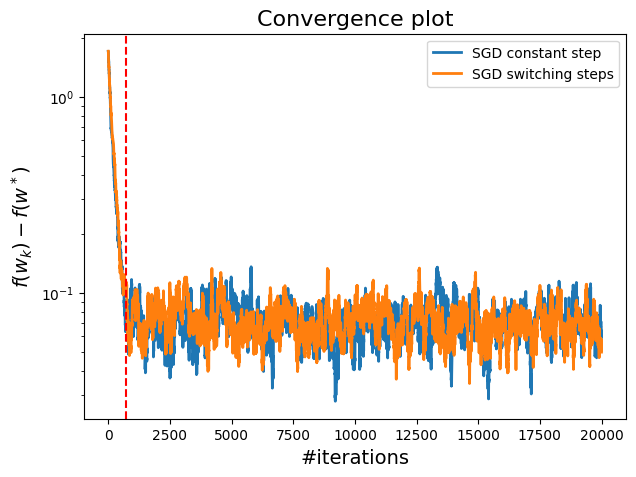

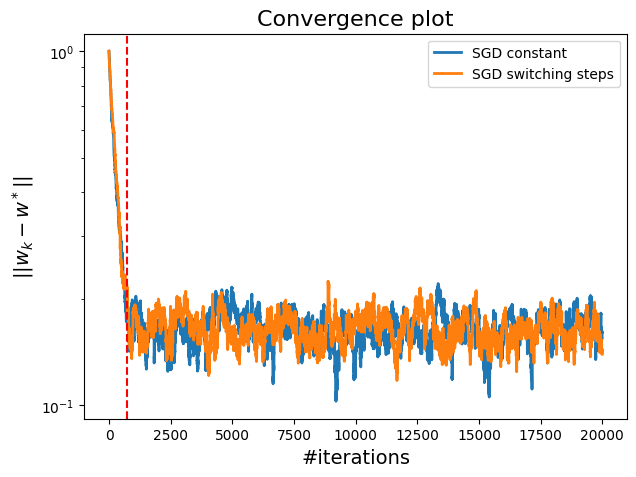

In [31]:
# Plotting to compare with constant stepsize 
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgdcr - obj_min, label="SGD constant step", lw=2)
plt.semilogy(obj_sgdss - obj_min, label="SGD switching steps", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("$f(w_k) - f(w^*)$", fontsize=14)
plt.legend()
plt.axvline(x=kstar, color = "red", linestyle='dashed')
#plt.savefig('images/sgd_switch_err.png', bbox_inches='tight')

# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.semilogy(err_sgdcr, label="SGD constant", lw=2)
plt.semilogy(err_sgdss , label="SGD switching steps", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("$|| w_k - w^* ||$", fontsize=14)
plt.legend()

plt.axvline(x=kstar,  color = "red", linestyle='dashed')
#plt.savefig('images/sgd_switch_dist.png', bbox_inches='tight')

## 5. Compare with averaging step

Let us fix for simplicity a starting point for half of $\texttt{maxiter}$.

In [32]:
indices = np.random.choice(n, n_iter+1, replace=True)

start_late_averaging1 = n_iter/2
averaging_on = True
w_sgdar, obj_sgdar, err_sgdar = sgd(w0,model, indices, steps_switch, w_min, n_iter, averaging_on, 0.0, True, start_late_averaging1) # (datapasses-5)*n

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 2.25e+00 | 1.00e+00
    1000 | 6.12e-01 | 1.77e-01
    2000 | 5.98e-01 | 1.64e-01
    3000 | 5.89e-01 | 1.52e-01
    4000 | 5.96e-01 | 1.57e-01
    5000 | 5.93e-01 | 1.54e-01
    6000 | 6.18e-01 | 1.74e-01
    7000 | 6.15e-01 | 1.69e-01
    8000 | 5.78e-01 | 1.37e-01
    9000 | 6.05e-01 | 1.67e-01
   10000 | 6.08e-01 | 1.62e-01
   11000 | 5.49e-01 | 8.37e-02
   12000 | 5.47e-01 | 7.84e-02
   13000 | 5.44e-01 | 7.17e-02
   14000 | 5.40e-01 | 5.85e-02
   15000 | 5.39e-01 | 5.28e-02
   16000 | 5.37e-01 | 4.51e-02
   17000 | 5.37e-01 | 4.31e-02
   18000 | 5.36e-01 | 4.05e-02
   19000 | 5.36e-01 | 3.61e-02


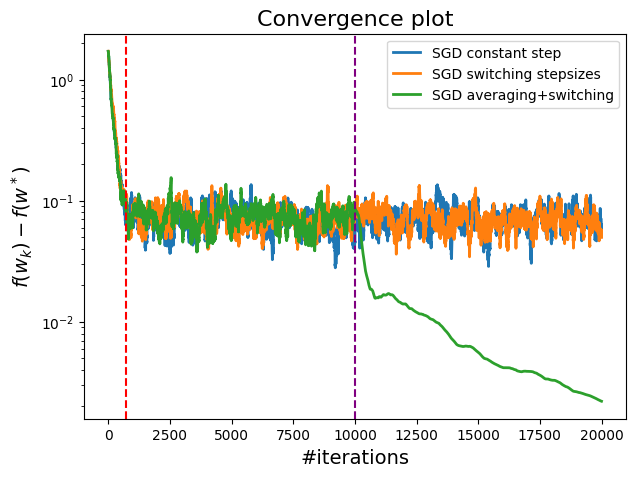

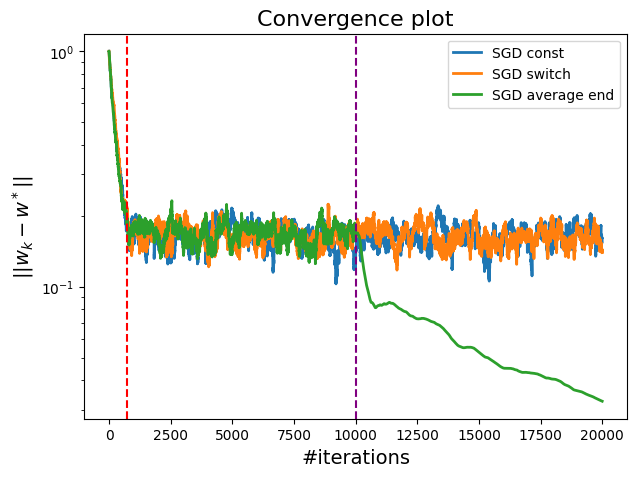

In [33]:
# Plotting to compare constant stepsize, switchting, switching + averaging
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgdcr - obj_min, label="SGD constant step", lw=2)
plt.semilogy(obj_sgdss - obj_min, label="SGD switching stepsizes", lw=2)
plt.semilogy(obj_sgdar - obj_min, label="SGD averaging+switching", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("$f(w_k) - f(w^*)$", fontsize=14)
plt.legend()
plt.axvline(x=kstar, color = "red", linestyle='dashed')
plt.axvline(x=start_late_averaging1, color = "purple", linestyle='dashed')
#plt.savefig('images/sgd_switch_average_err.png', bbox_inches='tight')
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(err_sgdcr, label="SGD const", lw=2)
plt.semilogy(err_sgdss , label="SGD switch", lw=2)
plt.semilogy(err_sgdar , label="SGD average end", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("$|| w_k - w^* ||$", fontsize=14)
plt.legend()
plt.axvline(x=kstar, color = "red", linestyle='dashed')
plt.axvline(x=start_late_averaging1, color = "purple", linestyle='dashed')
#plt.savefig('images/sgd_switch_average_dist.png', bbox_inches='tight')

## Compare with SGD with momentum (SGDm)

Let us introduce momentum in the main routine and add a flag momentum $\in[0,1]$ for calling it. Keep switching stepsizes and remove averaging (try to play with such parameters as you like).

In [39]:
indices = np.random.choice(n, n_iter+1, replace=True)
averaging_on = True
start_late_averaging = 0
momentum = 0.5
w_sgdm, obj_sgdm, err_sgdm = sgd(w0,model, indices, steps_switch, w_min, n_iter, averaging_on, momentum, True, start_late_averaging) # (datapasses-5)*n

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 2.25e+00 | 1.00e+00
    1000 | 5.73e-01 | 1.38e-01
    2000 | 5.44e-01 | 7.62e-02
    3000 | 5.41e-01 | 6.05e-02
    4000 | 5.39e-01 | 5.06e-02
    5000 | 5.37e-01 | 4.47e-02
    6000 | 5.37e-01 | 4.11e-02
    7000 | 5.36e-01 | 3.51e-02
    8000 | 5.36e-01 | 3.37e-02
    9000 | 5.36e-01 | 3.50e-02
   10000 | 5.36e-01 | 3.45e-02
   11000 | 5.36e-01 | 3.31e-02
   12000 | 5.35e-01 | 3.14e-02
   13000 | 5.35e-01 | 3.01e-02
   14000 | 5.35e-01 | 2.93e-02
   15000 | 5.35e-01 | 2.82e-02
   16000 | 5.35e-01 | 2.91e-02
   17000 | 5.35e-01 | 2.78e-02
   18000 | 5.35e-01 | 2.73e-02
   19000 | 5.34e-01 | 2.57e-02


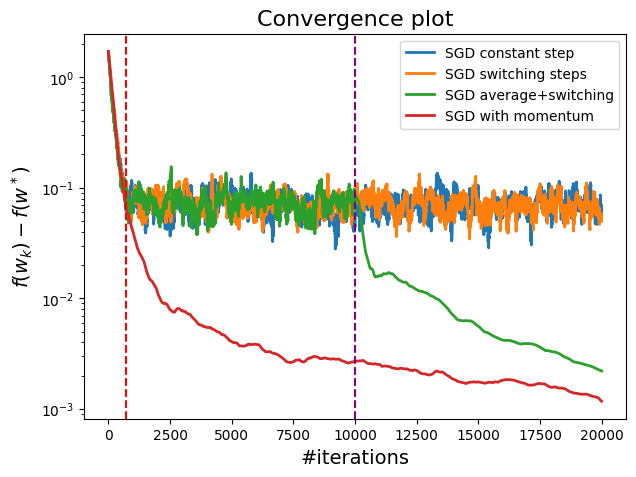

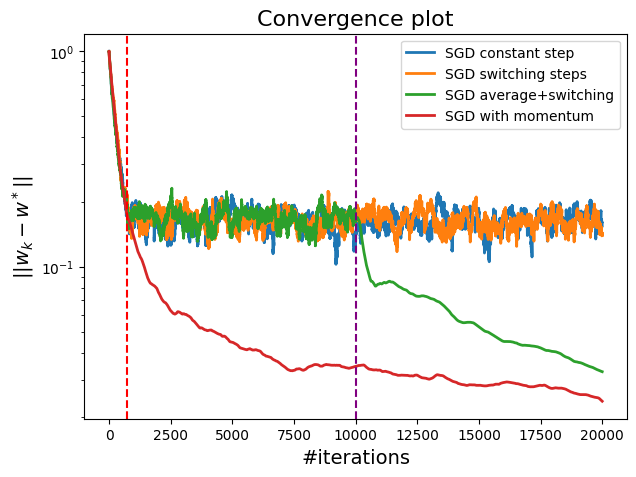

In [40]:
# Plotting to compare constant stepsize, switchting, switching + averaging
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgdcr - obj_min, label="SGD constant step", lw=2)
plt.semilogy(obj_sgdss - obj_min, label="SGD switching steps", lw=2)
plt.semilogy(obj_sgdar - obj_min, label="SGD average+switching", lw=2)
plt.semilogy(obj_sgdm - obj_min, label="SGD with momentum", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("$f(w_k) - f(w^*)$", fontsize=14)
plt.legend()
plt.axvline(x=kstar, color = "red", linestyle='dashed')
plt.axvline(x=start_late_averaging1, color = "purple", linestyle='dashed')
#plt.savefig('images/sgd_switch_average_err.png', bbox_inches='tight')
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(err_sgdcr, label="SGD constant step", lw=2)
plt.semilogy(err_sgdss , label="SGD switching steps", lw=2)
plt.semilogy(err_sgdar , label="SGD average+switching", lw=2)
plt.semilogy(err_sgdm , label="SGD with momentum", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("$|| w_k - w^* ||$", fontsize=14)
plt.legend()
plt.axvline(x=kstar, color = "red", linestyle='dashed')
plt.axvline(x=start_late_averaging1, color = "purple", linestyle='dashed')
#plt.savefig('images/sgd_switch_average_dist.png', bbox_inches='tight')